# CNN-Kim Model
I can't get it exactly the same now because I'm using custom-trained word vectors instead of pre-trained ones, but I can still try to build a similar architecture.

Since there are different variations of his model, I'll start with a model with the following architecture:
- Using custom-trained word vectors (dimension = 200)
- Keeping those word vectors static during the trainin process (maybe - TBD while implementing)
- Single-channel
- Filter windows height of 3, 4, 5 with 100 feature maps each
- MaxPooling to extract the features from each feature map
- Dropout rate of 0.5
- ReLu activation function 

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import ast
import tensorflow as tf
# from tensorflow_addons.metrics.hamming import hamming_loss_fn
# from tensorflow_addons.metrics import HammingLoss
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Check that a GPU is available
tf.config.experimental.list_physical_devices('GPU')

### Load in the data

In [3]:
# Load in the data
# data_list = [a, b, c, d, e, f, g, h, i ,f] = [None, None, None, None, None, None, None, None, None, None]
# data_list = [a, b, c, d, e] = [None, None, None, None, None]
data_list = [a] = [None]
data_location = '../Datasets/AmazonCat-13K/processed/' 
for i in range(len(data_list)):
    data_list[i] = pd.read_csv(data_location + f'tokenized_no{i + 1}.csv', encoding='latin1')
    
# Concatenate all the data and reset the index
data = pd.concat(data_list, sort=False)
data = data.reset_index()

# Delete unused var (so save memory)
del data_list

In [4]:
# Convery stringged arrays to arrays
data['tokenized_title_and_description'] = data['tokenized_title_and_description'].apply(ast.literal_eval)
data['labels'] = data['labels'].apply(ast.literal_eval)

In [5]:
# Check the first 3 rows
data.head(n=3)

In [6]:
# Check the shape
data.shape

### Prepare the X data

In [9]:
sequences = list(data['tokenized_title_and_description'])

In [10]:
# Add padding to the sequences
MAX_SEQUENCE_LENGTH = 500
padded_sequences = pad_sequences(sequences,
                                 maxlen=MAX_SEQUENCE_LENGTH,
                                 padding='post') # Add padding to the end if needs padding

### Prepare the y data

In [11]:
# Get the labels
all_labels = list(data['labels'])

In [12]:
# Get count of unique labels
unique_labels = []
for labels in all_labels:
    for label in labels:
        unique_labels.append(label)

# Get counts of labels and instnaces        
labels_count = len(set(unique_labels))
instances_count = data.shape[0]

# Delete unused var (to save memory)
del unique_labels

In [14]:
# Convert the tag sets into a sparse matrix of binary vectors (as int8 to save memory)
# Leaving it as a sparse matrix until after the train-test split will save a lot of memory 
mlb = MultiLabelBinarizer(sparse_output=True)
sparse_binary_vectors = mlb.fit_transform(all_labels).astype('int8')

In [15]:
# Delete unused vars (to save memory)
del all_labels
del data

### Prepare the data for training and testing

In [16]:
# Get the data
X = padded_sequences
y_sparse = sparse_binary_vectors

In [17]:
# Create the train-test split
X_train, X_test, y_train_sparse, y_test_sparse = train_test_split(X, y_sparse, test_size=0.25, random_state=100)

In [ ]:
# Delete unused vars (to save memory)
del X, padded_sequences
del y_sparse, sparse_binary_vectors, mlb

In [ ]:
# Convert the sparse matrixes into dense matrices (so they can be used in tensorflow)
y_train_placeholder = np.zeros((y_train_sparse.shape[0], labels_count), dtype='int8')
y_test_placeholder = np.zeros((y_test_sparse.shape[0], labels_count), dtype='int8')

# Get the dense vectors for training and testing
# This is done right at the end to save memory
y_train = y_train_sparse.todense(out=y_train_placeholder)
y_test = y_train_sparse.todense(out=y_test_placeholder)

In [ ]:
# Delete unused var (to save memory)
del y_train_placeholder
del y_test_placeholder

In [18]:
# Check X train and X test
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

X train shape: (560385, 500)
X test shape: (186795, 500)


In [19]:
# Check y train and y test
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

y train shape: (560385, 13531)
y test shape: (186795, 13531)


### Create the embedding layer

In [20]:
# Create the embedding layer definition
class PretrainedEmbedding(tf.keras.layers.Layer):
    """Non-trainable embedding layer."""

    def __init__(self, embeddings, dropout_rate=0.2, **kwargs):
        """"Instantiate the layer using a pre-defined embedding matrix."""
        super().__init__(**kwargs)
        self.embeddings = tf.constant(embeddings)
        # if you want to add some dropout (or normalization, etc.)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, inputs, training=None):
        """Embed some input tokens and optionally apply dropout."""
        output = tf.nn.embedding_lookup(self.embeddings, inputs)
        return self.dropout(output, training=training)

In [ ]:
# Load in the embedding matrix
embedding_matrix = np.loadtxt(data_location + 'embedding_matrix.csv', delimiter=',')

In [ ]:
# Check the embedding matrix size
embedding_matrix.shape

### Define the model layers

In [21]:
# Define the Input and Embedding layers
i = Input(shape=(MAX_SEQUENCE_LENGTH), dtype=tf.int32)
x = PretrainedEmbedding(embedding_matrix, dropout_rate=0)(i)

# Convolution with window size = 3  
x3 = Conv1D(filters=100, 
            kernel_size=3, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x3 = GlobalMaxPooling1D()(x3)

# Convolution with window size = 4
x4 = Conv1D(filters=100, 
            kernel_size=4, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x4 = GlobalMaxPooling1D()(x4)

# Convolution with window size = 5
x5 = Conv1D(filters=100, 
            kernel_size=5, 
            strides=1,
            padding='valid',
            activation='relu',
            use_bias=True
           )(x)
x5 = GlobalMaxPooling1D()(x5)

# Concatenated max-pooling layers with Dropout (CNN-Kim uses a dropout rate of 0.5)
concatenated = concatenate([x3, x4, x5])
x = Dropout(rate=0.5)(concatenated)

# Final, fully-connected Dense layer
x = Dense(y_train.shape[1], activation='sigmoid')(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [22]:
# Build the model
model = Model(i, x)

In [23]:
# Have a look at the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
pretrained_embedding (Pretraine (None, 500, 200)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 498, 100)     60100       pretrained_embedding[0][0]       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 497, 100)     80100       pretrained_embedding[0][0]       
______________________________________________________________________________________________

### Define how the model should be trained

In [24]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # CNN-Kim uses SGD with Adelta update rule
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

### Train the model

In [25]:
# Train the model
result = model.fit(X_train, y_train,
                   epochs=10,
                   validation_data=(X_test, y_test),
                   batch_size=100);

Train on 560385 samples, validate on 186795 samples
Epoch 1/10
560385/560385 [==============================] - 766s 1ms/sample - loss: 0.0047 - precision: 0.0346 - recall: 0.0811 - val_loss: 0.0019 - val_precision: 0.8633 - val_recall: 0.1147
Epoch 2/10
560385/560385 [==============================] - 746s 1ms/sample - loss: 0.0019 - precision: 0.7148 - recall: 0.1575 - val_loss: 0.0016 - val_precision: 0.8714 - val_recall: 0.1661
Epoch 3/10
560385/560385 [==============================] - 747s 1ms/sample - loss: 0.0017 - precision: 0.7119 - recall: 0.1971 - val_loss: 0.0015 - val_precision: 0.8632 - val_recall: 0.1954
Epoch 4/10
560385/560385 [==============================] - 744s 1ms/sample - loss: 0.0016 - precision: 0.7119 - recall: 0.2173 - val_loss: 0.0014 - val_precision: 0.8583 - val_recall: 0.2139
Epoch 5/10
560385/560385 [==============================] - 745s 1ms/sample - loss: 0.0015 - precision: 0.7131 - recall: 0.2304 - val_loss: 0.0013 - val_precision: 0.8658 - val_rec

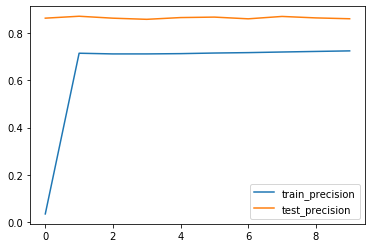

In [26]:
# Plot the precision metric at each itteration
plt.plot(result.history['precision'], label='train_precision');
plt.plot(result.history['val_precision'], label='test_precision');
plt.legend();

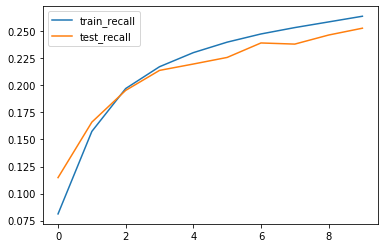

In [27]:
# Plot the recall metric at each itteration
plt.plot(result.history['recall'], label='train_recall');
plt.plot(result.history['val_recall'], label='test_recall');
plt.legend();